In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO, DQN
from gymnasium.wrappers import RecordVideo
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecVideoRecorder
import os 
import do_mpc
from casadi import vertcat

c:\Users\igrahek\AppData\Local\anaconda3\envs\shitty_bird_env\lib\site-packages\do_mpc\sysid\__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
c:\Users\igrahek\AppData\Local\anaconda3\envs\shitty_bird_env\lib\site-packages\do_mpc\opcua\__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


## Train the RL models

In [ ]:
rl_train_steps = 10000

# Create 'Results' folder if it doesn't exist
results_folder = "Results/Trained_Models/"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

#------------------------------------------------------------------------------------------------------------------------------------------------
# Train PPO model
#------------------------------------------------------------------------------------------------------------------------------------------------
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
ppo_model = PPO("MlpPolicy", env, verbose=1)
ppo_model.learn(total_timesteps=rl_train_steps)
ppo_model.save(os.path.join(results_folder, "ppo_cartpole_model_training_steps_" + str(rl_train_steps)))  # Save PPO model
env.close()

#------------------------------------------------------------------------------------------------------------------------------------------------
# Train DQN model
#------------------------------------------------------------------------------------------------------------------------------------------------
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
dqn_model = DQN("MlpPolicy", env, verbose=1)
dqn_model.learn(total_timesteps=rl_train_steps)
dqn_model.save(os.path.join(results_folder, "dqn_cartpole_model_training_steps_" + str(rl_train_steps)))  # Save PPO model

env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.6     |
|    ep_rew_mean     | 22.6     |
| time/              |          |
|    fps             | 3897     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26.7        |
|    ep_rew_mean          | 26.7        |
| time/                   |             |
|    fps                  | 2099        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009426999 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss   

## Specify the MPC model

In [ ]:
#------------------------------------------------------------------------------------------------------------------------------------------------
# Specify the MPC model
#------------------------------------------------------------------------------------------------------------------------------------------------
class MPCController:
    def __init__(self, horizon=10, dt=0.02, recompute_every=1):
        self.horizon = horizon  # Prediction steps
        self.dt = dt  # Time step
        self.recompute_every = recompute_every  # How often to recompute optimal actions
        self.force_mag = 10.0
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.length = 0.5  # Half-length of pole
        self.total_mass = self.masscart + self.masspole
        self.polemass_length = self.masspole * self.length

        # Define model
        model_type = "continuous"
        self.model = do_mpc.model.Model(model_type)
        
        x = self.model.set_variable(var_type='_x', var_name='x', shape=(1,1))
        x_dot = self.model.set_variable(var_type='_x', var_name='x_dot', shape=(1,1))
        theta = self.model.set_variable(var_type='_x', var_name='theta', shape=(1,1))
        theta_dot = self.model.set_variable(var_type='_x', var_name='theta_dot', shape=(1,1))
        u = self.model.set_variable(var_type='_u', var_name='u', shape=(1,1))
        
        costheta = np.cos(theta)
        sintheta = np.sin(theta)
        temp = (u + self.polemass_length * theta_dot**2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
        
        self.model.set_rhs('x', x_dot)
        self.model.set_rhs('x_dot', xacc)
        self.model.set_rhs('theta', theta_dot)
        self.model.set_rhs('theta_dot', thetaacc)
        
        self.model.setup()
        
        # Define MPC controller
        self.mpc = do_mpc.controller.MPC(self.model)
        setup_mpc = {
            'n_horizon': self.horizon,
            't_step': self.dt,
            'n_robust': 0,
            'state_discretization': 'collocation',
            'collocation_type': 'radau',
            'collocation_deg': 2,
            'collocation_ni': 1,
            'store_full_solution': False,
        }
        self.mpc.set_param(**setup_mpc)
        
        self.mpc.set_objective(mterm=theta**2 + x**2, lterm=theta**2 + x**2 + 0.01*u**2)
        self.mpc.bounds['lower','_u','u'] = -self.force_mag
        self.mpc.bounds['upper','_u','u'] = self.force_mag
        
        self.mpc.setup()

    def get_action(self, obs):
        self.mpc.x0 = np.array(obs).reshape(-1, 1)
        self.mpc.set_initial_guess()
        u_opt = self.mpc.make_step(self.mpc.x0)
        return float(u_opt[0])

## Test the models

In [ ]:
SEED = 42
rl_train_steps = 100000
num_episodes = 20
horizons = [10, 50]
recompute_intervals = [1, 5]

# Ensure results folder exists
results_folder = "Results/Trained_Models/"
os.makedirs(results_folder, exist_ok=True)

#------------------------------------------------------------------------------------------------------------------------------------------------
# Evalueate the RL models
#------------------------------------------------------------------------------------------------------------------------------------------------

# Load models
ppo_model = PPO.load(os.path.join(results_folder, f"ppo_cartpole_model_training_steps_{rl_train_steps}"))
dqn_model = DQN.load(os.path.join(results_folder, f"dqn_cartpole_model_training_steps_{rl_train_steps}"))
print("Loaded PPO and DQN models.")

# Function to evaluate a model
def evaluate_model(model, model_name):
    episode_lengths = []
    for episode in range(num_episodes):
        test_env = gym.make("CartPole-v1", render_mode="rgb_array")
        video_filename = f"Results/Videos/{model_name}/rl_training_steps_{rl_train_steps}_episode_{episode + 1}.mp4"
        test_env = gym.wrappers.RecordVideo(test_env, video_filename, episode_trigger=lambda _: True)
        obs, _ = test_env.reset(seed=SEED+episode)
        episode_length = 0
        done = False
        while not done and episode_length < 500:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, _, _ = test_env.step(action)
            episode_length += 1
        episode_lengths.append(episode_length)
        test_env.close()
    return episode_lengths

# Evaluate PPO and DQN models
ppo_episode_lengths = evaluate_model(ppo_model, "ppo")
dqn_episode_lengths = evaluate_model(dqn_model, "dqn")

# Save the results
results_folder = "Results/PerformanceResults/"
os.makedirs(results_folder, exist_ok=True)
np.savetxt(os.path.join(results_folder, f"ppo_episode_lengths_rl_training_steps_{rl_train_steps}.csv"), ppo_episode_lengths, delimiter=",")
np.savetxt(os.path.join(results_folder, f"dqn_episode_lengths_rl_training_steps_{rl_train_steps}.csv"), dqn_episode_lengths, delimiter=",")

#------------------------------------------------------------------------------------------------------------------------------------------------
# Evalueate the MPC models
#------------------------------------------------------------------------------------------------------------------------------------------------

# Evaluate MPC models
mpc_results = {}
for horizon in horizons:
    for recompute_every in recompute_intervals:
        key = f"h_{horizon}_e_{recompute_every}"
        mpc_results[key] = []
        mpc = MPCController(horizon=horizon, recompute_every=recompute_every)
        
        for episode in range(num_episodes):
            test_env = gym.make("CartPole-v1", render_mode="rgb_array")
            video_filename = f"Results/Videos/mpc_horizon_{horizon}_recompute_{recompute_every}/episode_{episode + 1}.mp4"
            test_env = gym.wrappers.RecordVideo(test_env, video_filename, episode_trigger=lambda _: True)
            obs, _ = test_env.reset(seed=SEED+episode)
            episode_length = 0
            step = 0
            done = False
            while not done and episode_length < 500:
                if step % recompute_every == 0:
                    action = 1 if mpc.get_action(obs) > 0 else 0
                obs, _, done, _, _ = test_env.step(action)
                step += 1
                episode_length += 1
            mpc_results[key].append(episode_length)
            test_env.close()

# Save results
results_folder = "Results/PerformanceResults/"
os.makedirs(results_folder, exist_ok=True)
for key, lengths in mpc_results.items():
    np.savetxt(os.path.join(results_folder, f"mpc_episode_lengths_{key}.csv"), lengths, delimiter=",")


Loaded PPO and DQN models.


## Plot the results

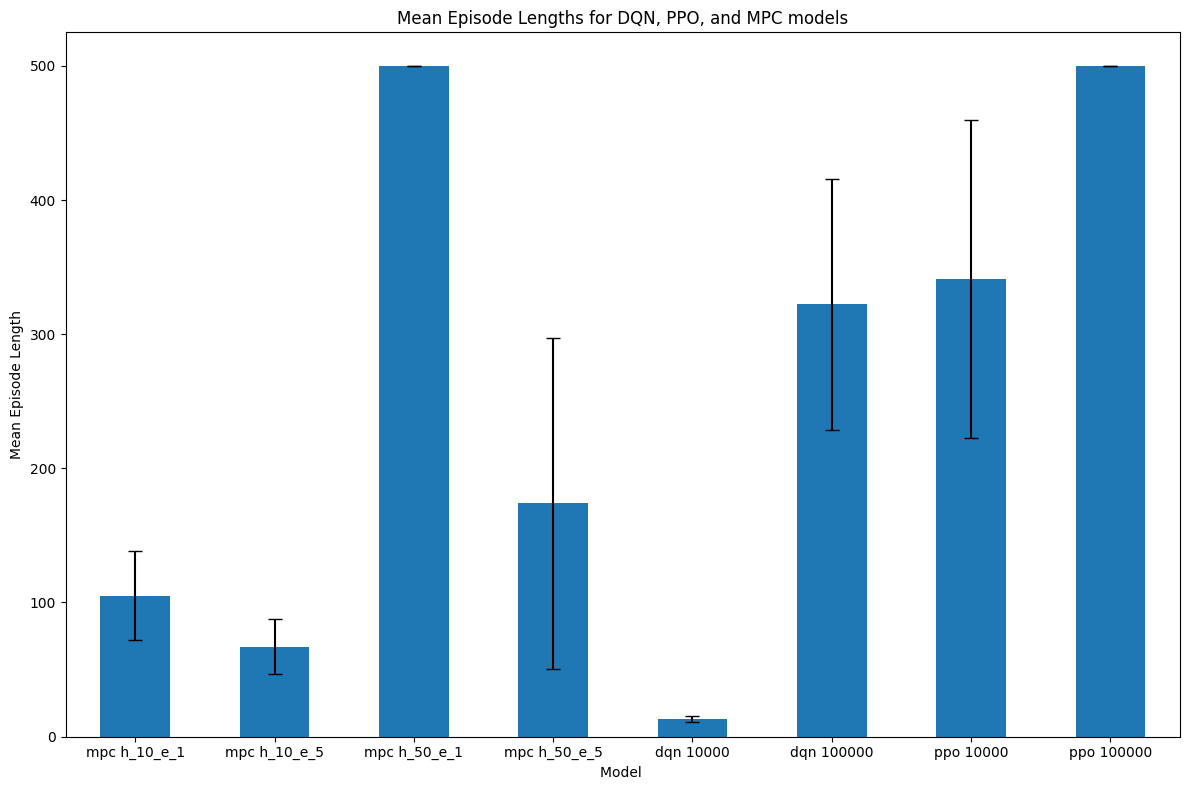

In [38]:
# Read each of the files and calculate the mean and standard deviation of the episode lengths. save the model name (first 3 letters of the file name), and the model specification after the 2nd underscore
results = []
for file in files:
    data = np.loadtxt(os.path.join(results_folder, file), delimiter=",")
    mean = np.mean(data)
    std = np.std(data)
    model_name = file[:3]
    model_spec = file.split("_")[3:]
    results.append([model_name, model_spec, mean, std])

# For dqn and ppo, reduce the second variable to the 4th element minus .csv. For mpc, reduce the second variable to the combination of all elements minus .csv
for i, result in enumerate(results):
    if result[0] in ["dqn", "ppo"]:
        results[i][1] = result[1][3][:-4]
    else:
        results[i][1] = "_".join(result[1][:])
        results[i][1] = results[i][1][:-4]

# Make a barplot with the mean episode lengths and standard deviations. Make dqn go first, then ppo, then mpc
results.sort(key=lambda x: x[0])
results.sort(key=lambda x: x[0] != "mpc")
results

# Make a dataframe
df = pd.DataFrame(results, columns=["Model", "Specification", "Mean Episode Length", "Standard Deviation"])

# Combine Model and Specification into a single column
df["Model"] = df["Model"] + " " + df["Specification"]

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
df.plot(kind="bar", x="Model", y="Mean Episode Length", yerr="Standard Deviation", ax=ax, capsize=5)
plt.xlabel("Model ")
plt.xticks(rotation=0)  
plt.ylabel("Mean Episode Length")
plt.title("Mean Episode Lengths for DQN, PPO, and MPC models")
plt.tight_layout()
# remove the legend
ax.get_legend().remove()
plt.show()

# Save in Results/PerformanceResults
results_folder = "Results/PerformanceResults/"
os.makedirs(results_folder, exist_ok=True)
df.to_csv(os.path.join(results_folder, "mean_episode_lengths.csv"), index=False)
fig.savefig(os.path.join(results_folder, "mean_episode_lengths.png"), bbox_inches="tight", dpi=300)




In [27]:
df

,Model,Specification,Mean Episode Length,Standard Deviation
0,mpc,h_10_e_1,105.05,33.111139
1,mpc,h_10_e_5,67.00,20.579116
2,mpc,h_50_e_1,500.00,0.000000
3,mpc,h_50_e_5,173.80,123.346504
4,dqn,10000,12.85,2.197157
5,dqn,100000,322.35,93.613714
6,ppo,10000,341.15,118.543357
7,ppo,100000,500.00,0.000000


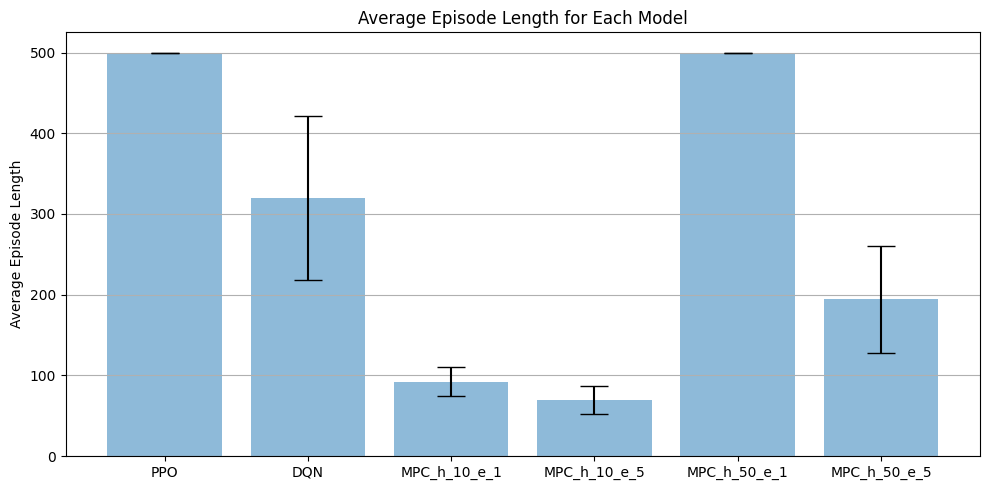

In [ ]:
# Plot and save average episode lengths for each model as a barplot with mean and standard deviation
ppo_mean = np.mean(ppo_episode_lengths)
ppo_std = np.std(ppo_episode_lengths)
dqn_mean = np.mean(dqn_episode_lengths)
dqn_std = np.std(dqn_episode_lengths)
mpc_mean_h_10_e_1 = np.mean(mpc_episode_lengths_h_10_e_1)
mpc_std_h_10_e_1 = np.std(mpc_episode_lengths_h_10_e_1)
mpc_mean_h_50_e_1 = np.mean(mpc_episode_lengths_h_50_e_1)
mpc_std_h_50_e_1 = np.std(mpc_episode_lengths_h_50_e_1)
mpc_mean_h_10_e_5 = np.mean(mpc_episode_lengths_h_10_e_5)
mpc_std_h_10_e_5 = np.std(mpc_episode_lengths_h_10_e_5)
mpc_mean_h_50_e_5 = np.mean(mpc_episode_lengths_h_50_e_5)
mpc_std_h_50_e_5 = np.std(mpc_episode_lengths_h_50_e_5)

fig, ax = plt.subplots()
models = ["PPO", "DQN", "MPC_h_10_e_1", "MPC_h_10_e_5", "MPC_h_50_e_1", "MPC_h_50_e_5"]
means = [ppo_mean, dqn_mean, mpc_mean_h_10_e_1, mpc_mean_h_10_e_5, mpc_mean_h_50_e_1, mpc_mean_h_50_e_5]
stds = [ppo_std, dqn_std, mpc_std_h_10_e_1, mpc_std_h_10_e_5, mpc_std_h_50_e_1, mpc_std_h_50_e_5]

ax.bar(models, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Average Episode Length')
ax.set_title('Average Episode Length for Each Model')
ax.yaxis.grid(True)
plt.tight_layout()
plt.savefig("Results/average_episode_lengths.png")